In [1]:
import pandas as pd
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE

import main
drive_path = r"\\NERFHF01/djnerf1/VEIDB/"
# data_path = r"Y:\Data"
data_path =r"V:\Data/"
ft = main.load(drive_path, data_path)

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [85]:
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import os
sb.set_style('dark')

In [88]:
""" Define path to results folder. """
results_path = r'E:\data\GRP_optotagged'
if not os.path.isdir(results_path):
    os.mkdir(results_path)

['2P', 'SCEphys', 'VEIDB', 'mysql', 'performance_schema', 'sys', 'test', 'tutorial']


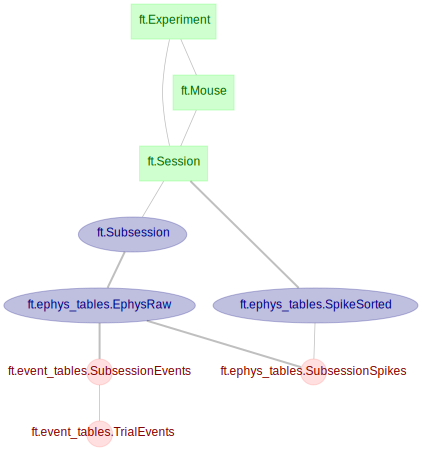

In [3]:
print(dj.list_schemas())
dj.Di(ft.schema)

In [4]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_tables = ft.ephys_tables.EphysRaw()
subsess_events_table = ft.event_tables.SubsessionEvents()

sorted_table = ft.ephys_tables.SpikeSorted()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

In [5]:
subsess_spikes_table

experiment_id,mouse_id,session_id,subsession_id,subsession_type,start_abs,clusters,cluster_annot
01437,M02,20201214,EXD_1_0001,EXD,0,=BLOB=,=BLOB=
01437,M02,20201214,EXD_2_0001,EXD,63384371,=BLOB=,=BLOB=
01437,M02,20201214,EXD_3_0001,EXD,144285767,=BLOB=,=BLOB=
01437,M02,20201214,OPTS_1_0001,OPTS,205696127,=BLOB=,=BLOB=


In [79]:
trials_expa = (trial_events_table & {'stimtype': 'EXPA'})
trials_expa

experiment_id,mouse_id,session_id,subsession_id,trial_id,trial_iter,stimtype,start,end,events
01437,M02,20201214,EXD_1_0001,EXD_T2,2,EXPA,12237621,12519461,=BLOB=
01437,M02,20201214,EXD_1_0001,EXD_T6,6,EXPA,36585995,36868336,=BLOB=
01437,M02,20201214,EXD_1_0001,EXD_T7,7,EXPA,49228661,49510765,=BLOB=
01437,M02,20201214,EXD_2_0001,EXD_T1,1,EXPA,7065690,7347996,=BLOB=
01437,M02,20201214,EXD_2_0001,EXD_T5,5,EXPA,37444502,37726838,=BLOB=
01437,M02,20201214,EXD_2_0001,EXD_T7,7,EXPA,56999423,57281736,=BLOB=
01437,M02,20201214,EXD_3_0001,EXD_T0,0,EXPA,63416,345528,=BLOB=
01437,M02,20201214,EXD_3_0001,EXD_T2,2,EXPA,15118097,15400451,=BLOB=
01437,M02,20201214,EXD_3_0001,EXD_T3,3,EXPA,26710765,26992892,=BLOB=


In [97]:
def filter_clusters(clusters, annot=['good']):
    clusters_filtered = {}
    for c in cluster_annot:
        if cluster_annot[c] in annot:
            clusters_filtered[c] = clusters.get(c)
    return clusters_filtered
                

def plot_spike_raster(clusters, start, end, ax, event_times=None):
    data = []

    for c, cl_spike_times in clusters.items():
        if cl_spike_times is not None and isinstance(cl_spike_times, np.ndarray):
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            data.append((c, cl_spike_times_sub))
            
    for i, (cluster, cl_spike_times) in enumerate(data[:]):
        ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*cluster*1, marker='|', c='k') # SCATTER PLOT
    
    ax.set_ylabel('neurons')
#     ax.set_xlabel('time (s)')
    if event_times is not None:
        event_types_and_times = list(zip(*[(i, t) for tup in event_times for (i, t) in enumerate(tup)]))
        event_types = np.array(event_types_and_times[0]) 
        event_times = np.array(event_types_and_times[1])
        event_times_sub = event_times[(event_times >= start) & (event_times < end)]
        event_types_sub = event_types[(event_times >= start) & (event_times < end)]
        for event in event_times_sub:
            ax.axvline(event/30000, ymin=0, ymax=1, c='r', alpha=0.8)

In [98]:
trial['events']

[(26711298, 26720793, 26736302),
 (26781797, 26791294, 26806795),
 (26852297, 26861792, 26877297),
 (26922797, 26932292, 26947797)]

## Spike raster plots

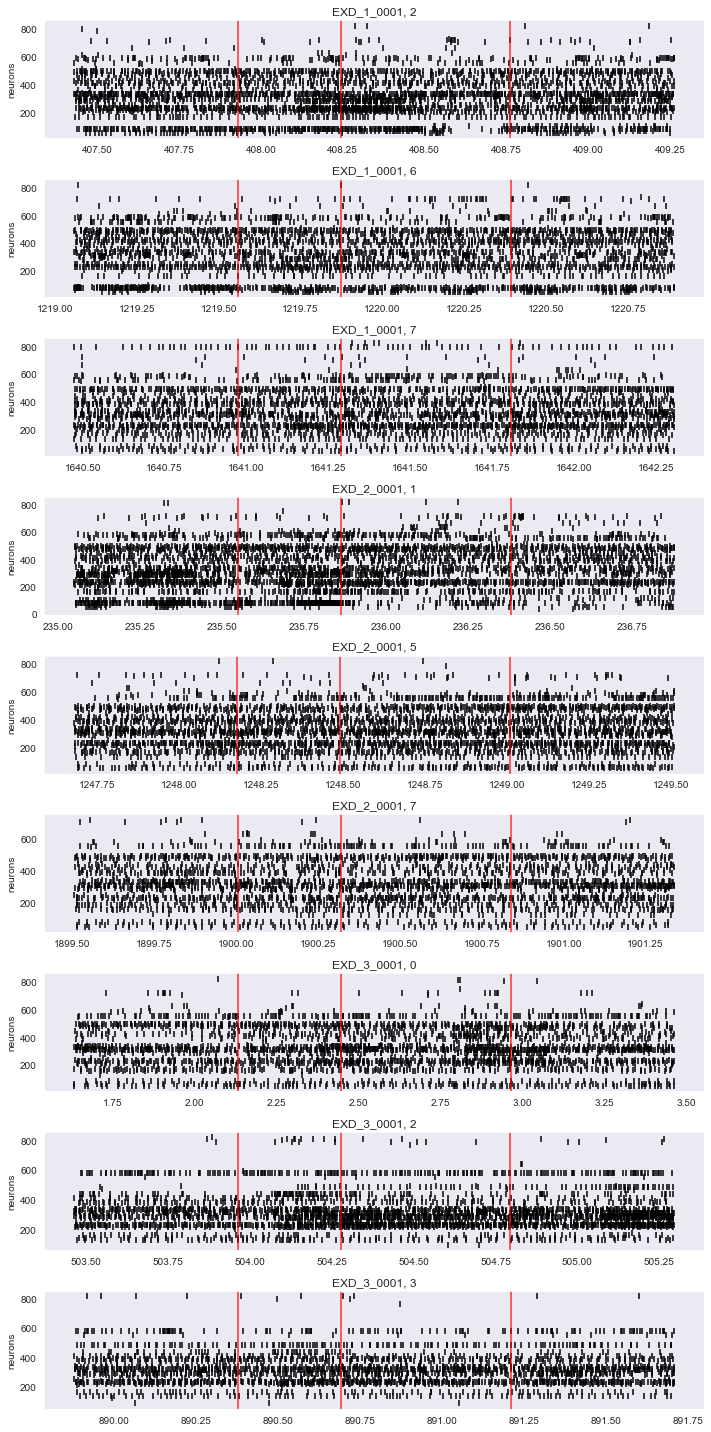

In [99]:
fig, axs = plt.subplots(len(trials_expa), 1, figsize=(10, 20))

for i, trial in enumerate(trials_expa):
#     print(trial)
    clusters, cluster_annot = (subsess_spikes_table & trial).fetch1('clusters', 'cluster_annot')
    clusters_good = filter_clusters(clusters, annot=['good'])
#     plot_spike_raster(clusters, cluster_annot, trial['start'], trial['end'], axs[i])
    plot_spike_raster(clusters_good, trial['events'][0][0]-15000, trial['events'][0][2]+15000, axs[i], trial['events'])
    axs[i].set_title(f"{trial['subsession_id']}, {trial['trial_iter']}")

#     break
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'spikeraster_expa.png'))


## Firing rates

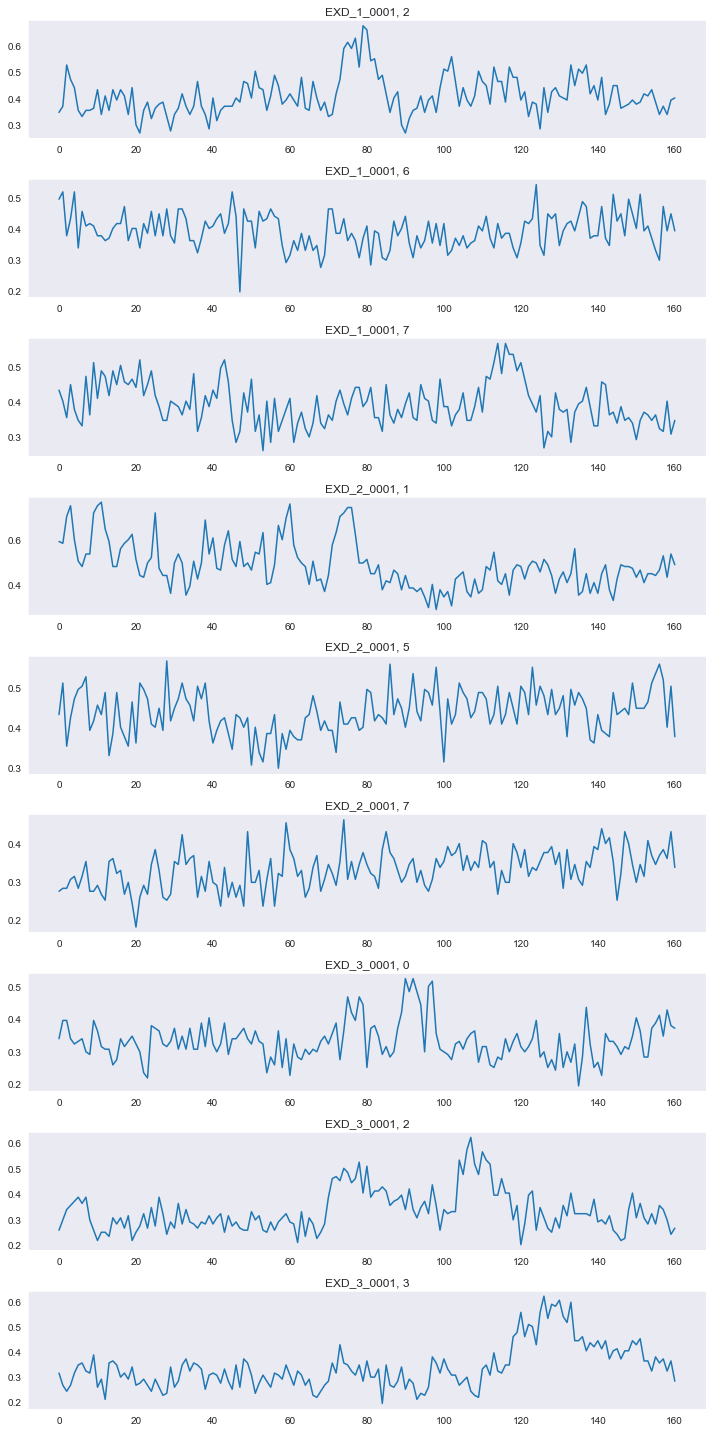

In [111]:
def spikes_2_firingrate(clusters, start, end, n_neurons=1, binsize=30, stride=5):
    first_spike_time = min([s[0] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0])    
    last_spike_time = max([s[-1] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0])    

    fr_clusters = {}
    for i, (c, cl_spike_times) in enumerate(clusters.items()):
        if cl_spike_times is not None:
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            fr, _ = np.histogram(cl_spike_times_sub, bins=np.arange(start, end, (30000/1000)*binsize))
            fr_clusters[c] = fr
    return fr_clusters

def plot_firing_rates(fr_clusters, ax, mean=True, event_times=None):
    trial_frs = []
    for j, (c, firing_rate) in enumerate(fr_clusters.items()):
#         axs[i].plot(np.ones_like(firing_rate)*c*1, firing_rate)
        trial_frs.append(firing_rate)
    ax.plot(np.mean(np.array(trial_frs), axis=0))


fig, axs = plt.subplots(len(trials_expa), 1, figsize=(10, 20))

for i, trial in enumerate(trials_expa):
    clusters, cluster_annot = (subsess_spikes_table & trial).fetch1('clusters', 'cluster_annot')
    clusters_good = filter_clusters(clusters, annot=['good'])
    fr_clusters = spikes_2_firingrate(clusters_good, trial['events'][0][0]-60000, trial['events'][0][2]+60000, binsize=30)
    
    plot_firing_rates(fr_clusters, axs[i])
    axs[i].set_title(f"{trial['subsession_id']}, {trial['trial_iter']}")
    
plt.tight_layout()
plt.show()
# """ Convert spikes to firing rates"""

# last_spike_time = max([s[-1] for s in spikes if isinstance(s, np.ndarray) and len(s)>0])
# firing_rates = np.zeros((len(spikes), int(last_spike_time*(1000/(30000*fr_binsize)))))
# print(last_spike_time)
# print(firing_rates.shape)
# for i, unit_spikes in enumerate(spikes):
#     fr, _ = np.histogram(unit_spikes, bins=np.arange(0, last_spike_time, (30000/1000)*fr_binsize))
#     firing_rates[i] = fr - np.mean(fr)

In [112]:
np.convolve([1, 1 ,1], [1, 0, 0, 1, 1, 1])

array([1, 1, 1, 1, 2, 3, 2, 1])

In [125]:
""" Normal histogram """
first_spiketime = 0
last_spiketime = 6
bin_size = 2
spiketimes = np.array([0, 2, 3, 6])
n_buckets = int(np.ceil((last_spiketime-first_spiketime)/bin_size)) + 1
counts = np.zeros(shape=(n_buckets))


def transfer(t):
    return (t-first_spiketime)//bin_size

for time in spiketimes:
    counts[transfer(time)] += 1
counts

array([1., 2., 0., 1.])

In [146]:
first_spiketime = 0
last_spiketime = 6
bin_size = 2
spiketimes = np.array([0, 2, 3, 6])
n_buckets = (last_spiketime-first_spiketime)+1-(bin_size-1)
# n_buckets = int(np.ceil((last_spiketime-first_spiketime)/bin_size)) + 1
counts = np.zeros(shape=(n_buckets))


def transfer(t):
    return np.arange(t-first_spiketime, (t-first_spiketime)+bin_size, 1)#np.array([t-first_spiketime])
#     return (t-first_spiketime)//bin_size

for time in spiketimes:
    counts[transfer(time)] += 1
counts

IndexError: index 6 is out of bounds for axis 0 with size 6